In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from neuralprophet import NeuralProphet
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [6]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [7]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

# Baseline Prophet on df_train для проверки модели

In [4]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df_train)

01:06:12 - cmdstanpy - INFO - Chain [1] start processing
01:06:14 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)

In [6]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2643,2024-01-02,11.668106,9.309167,14.028745
2644,2024-01-03,11.706958,9.253656,14.190319
2645,2024-01-04,11.679773,9.231668,14.137768
2646,2024-01-05,11.667734,9.354907,14.134596
2647,2024-01-06,12.424644,10.048822,14.939899


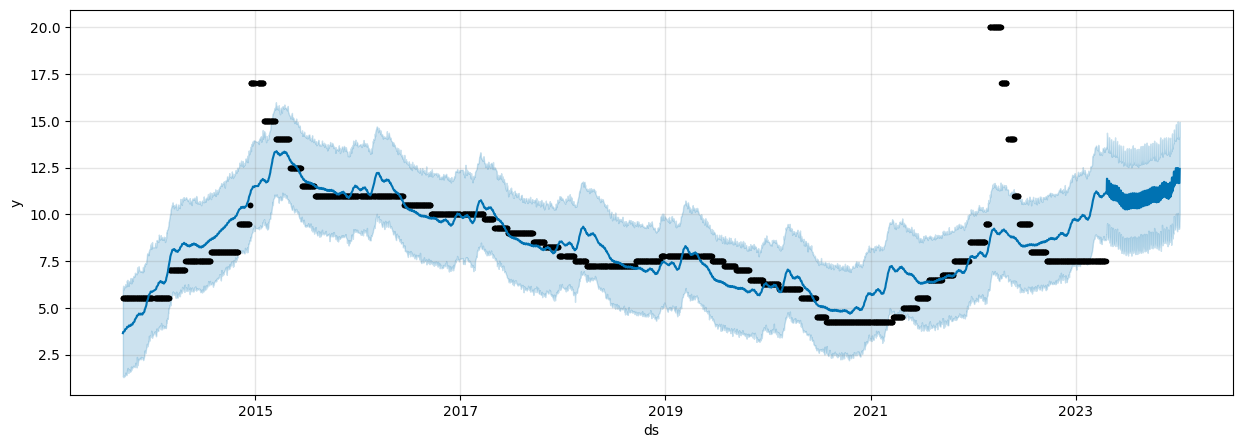

In [7]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

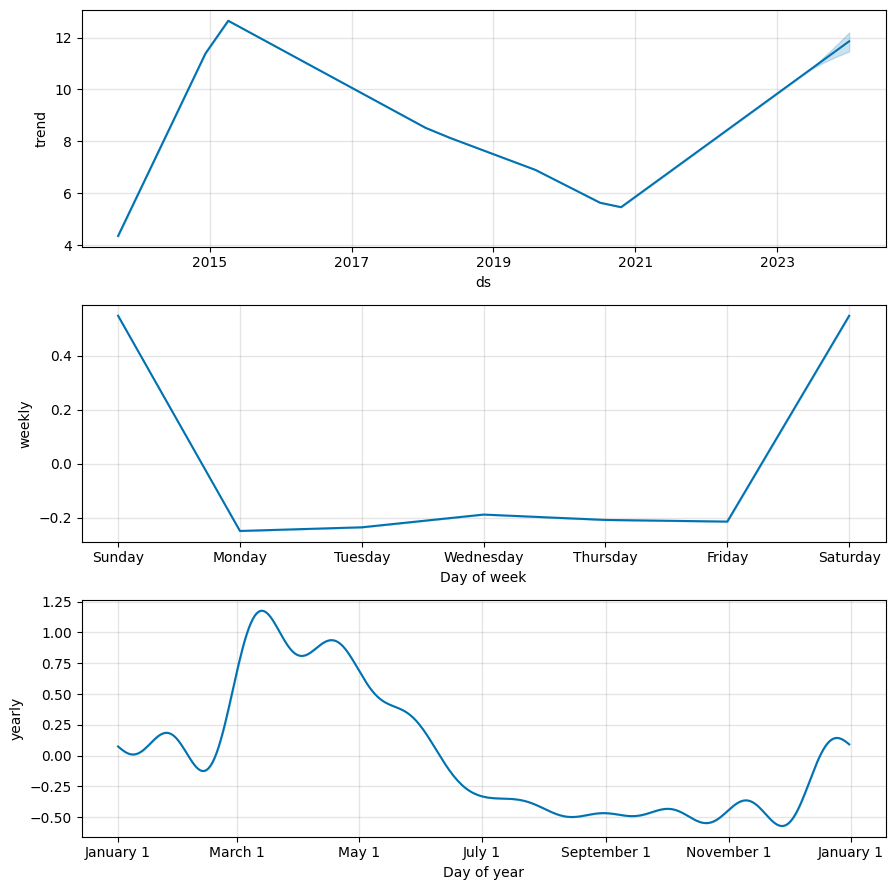

In [8]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [9]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-24,13.121160,10.618948,15.645228
260,2024-04-25,13.084991,10.482657,15.553642
261,2024-04-26,13.060555,10.604753,15.599702
262,2024-04-29,12.962613,10.495200,15.558353
263,2024-04-30,12.953640,10.476558,15.265841


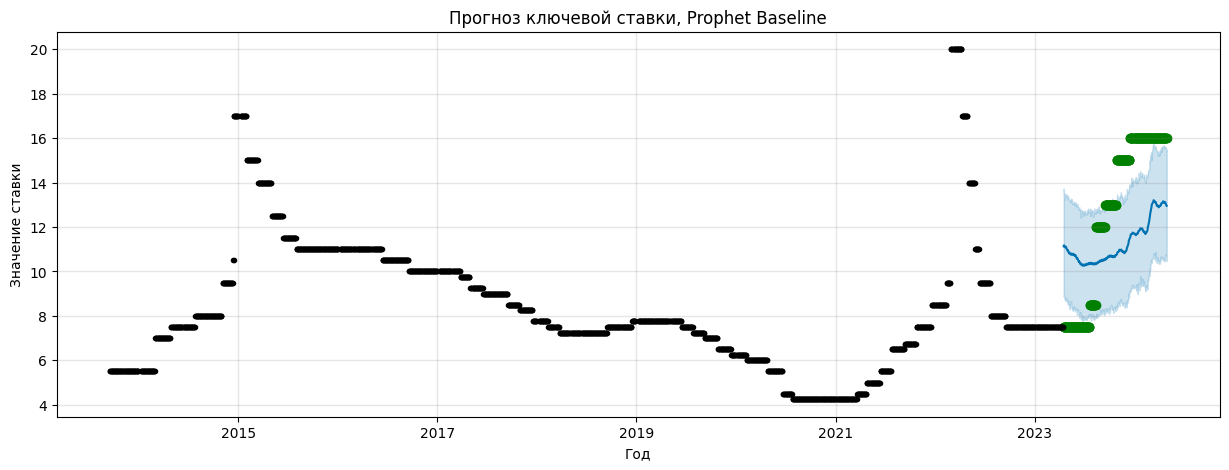

In [10]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

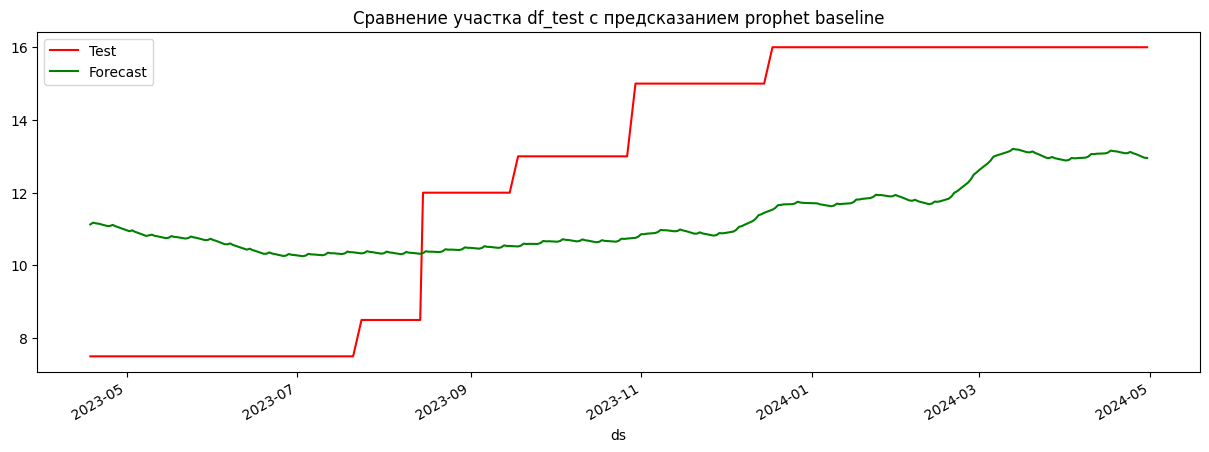

In [11]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [12]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.109367,0.264669,10.423208,3.228499


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [13]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [14]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

01:06:25 - cmdstanpy - INFO - Chain [1] start processing
01:06:27 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2643,2024-01-02,11.132076,8.464872,13.673987
2644,2024-01-03,11.178290,8.777135,13.539525
2645,2024-01-04,11.148211,8.611198,13.406928
2646,2024-01-05,11.142840,8.706774,13.500563
2647,2024-01-06,11.933907,9.657993,14.404405


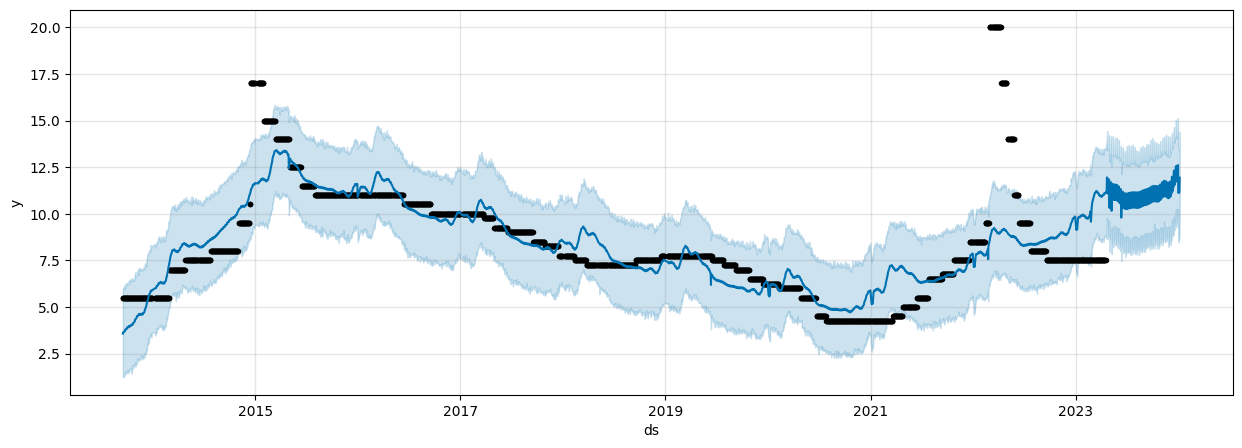

In [16]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

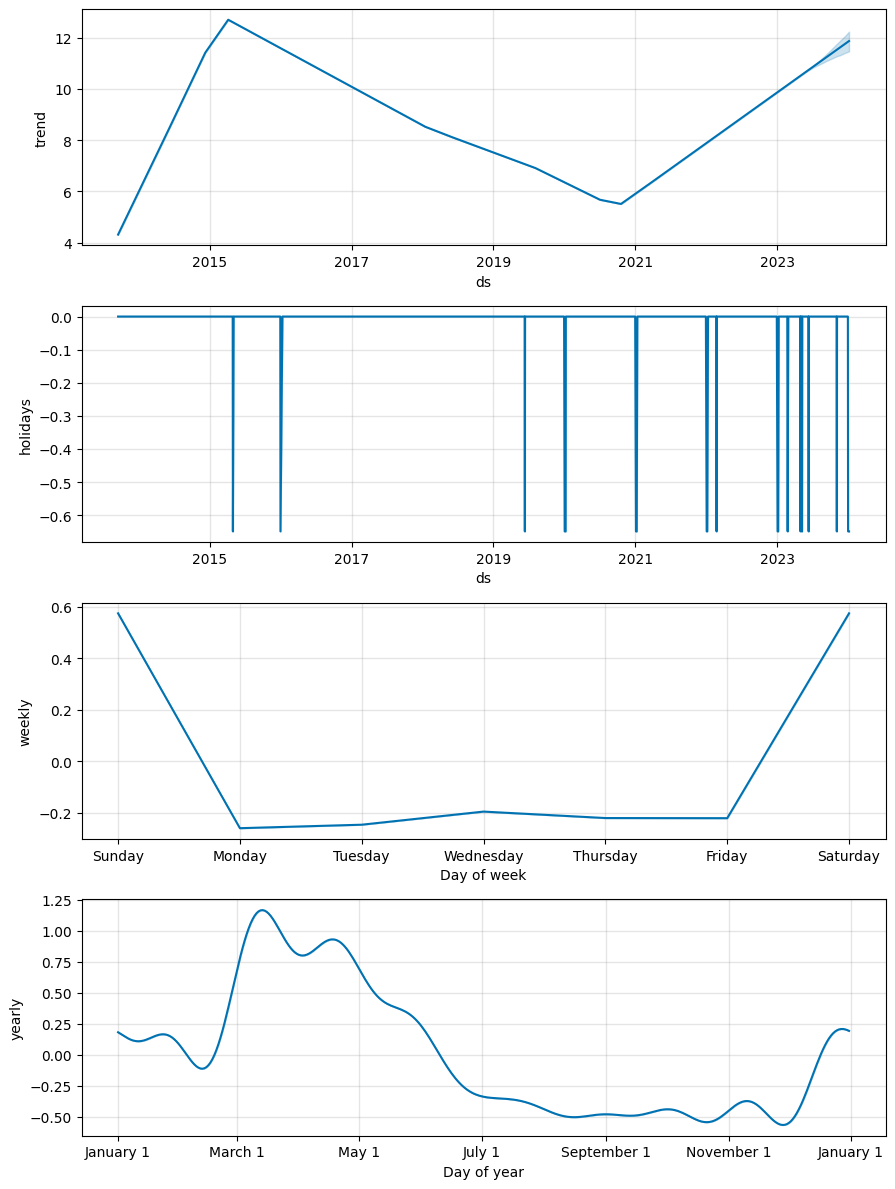

In [17]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [18]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-24,13.132583,10.717796,15.690966
260,2024-04-25,13.092159,10.555178,15.607532
261,2024-04-26,13.074045,10.558674,15.599714
262,2024-04-29,12.972470,10.524351,15.448583
263,2024-04-30,12.963131,10.520692,15.543761


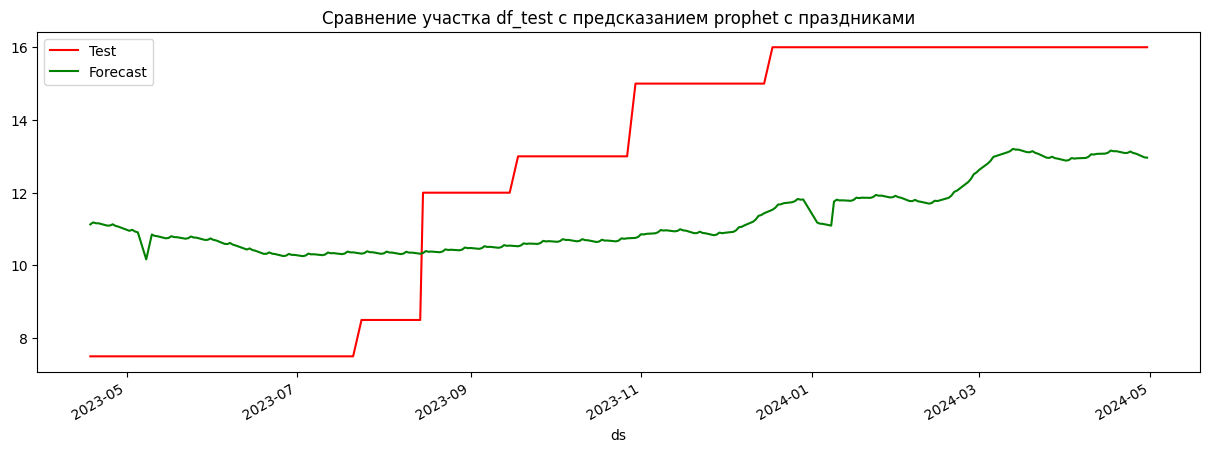

In [19]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [20]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.109367,0.264669,10.423208,3.228499
0,Prophet_with_holidays,3.111239,0.264666,10.450544,3.232730


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [21]:
# Создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [22]:
"""Обучение тестовой модели по сетке параметров"""
# Создаем пустой DataFrame для сохранения метрик и параметров
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    #print(p)
#for p in grid:
#    print(p)
    
    # Создаем модель Prophet с текущими гиперпараметрами
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #daily_seasonality = p['daily_seasonality'],
        #weekly_seasonality = p['weekly_seasonality'],
        #yearly_seasonality = p['yearly_seasonality'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель данными
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)


  0%|          | 0/672 [00:00<?, ?it/s]

01:06:35 - cmdstanpy - INFO - Chain [1] start processing
01:06:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/672 [00:02<30:52,  2.76s/it]01:06:38 - cmdstanpy - INFO - Chain [1] start processing
01:06:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/672 [00:05<31:15,  2.80s/it]01:06:41 - cmdstanpy - INFO - Chain [1] start processing
01:06:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/672 [00:08<30:55,  2.77s/it]01:06:43 - cmdstanpy - INFO - Chain [1] start processing
01:06:44 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/672 [00:10<27:34,  2.48s/it]01:06:45 - cmdstanpy - INFO - Chain [1] start processing
01:06:46 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/672 [00:12<26:17,  2.37s/it]01:06:48 - cmdstanpy - INFO - Chain [1] start processing
01:06:48 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/672 [00:15<26:52,  2.42s/it]01:06:50 - cmdstanpy - INFO - Chain [1] 

In [23]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [24]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,5.757434,0.394285,47.422437,6.886395,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,5.883178,0.403989,49.287550,7.020509,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,6.033167,0.416752,51.142928,7.151428,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,6.076609,0.420602,51.662294,7.187649,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,5.717549,0.391236,46.911859,6.849223,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,12.831487,1.027459,305.326866,17.473605,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,4.324770,0.329537,22.541527,4.747792,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,4.421930,0.336416,23.614899,4.859516,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,4.424806,0.335611,23.760884,4.874514,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [25]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.609482,0.302997,14.408703,3.79588,"{'changepoint_prior_scale': 0.06, 'holidays_pr..."
1,Prophet_with_grid,3.609482,0.302997,14.408703,3.79588,"{'changepoint_prior_scale': 0.06, 'holidays_pr..."
2,Prophet_with_grid,3.609482,0.302997,14.408703,3.79588,"{'changepoint_prior_scale': 0.06, 'holidays_pr..."
3,Prophet_with_grid,3.609482,0.302997,14.408703,3.79588,"{'changepoint_prior_scale': 0.06, 'holidays_pr..."
4,Prophet_with_grid,3.612852,0.302959,14.461819,3.80287,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."


## Лучшие параметры после обучения по сетке

In [26]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params

{'changepoint_prior_scale': 0.06,
 'holidays_prior_scale': 1,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}

In [27]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

01:25:41 - cmdstanpy - INFO - Chain [1] start processing
01:25:42 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2643,2024-01-02,11.709306,9.282828,14.073013
2644,2024-01-03,11.747686,9.281321,14.080215
2645,2024-01-04,11.721085,9.204272,14.020130
2646,2024-01-05,11.708652,9.190970,14.026487
2647,2024-01-06,12.378896,9.979878,14.711857


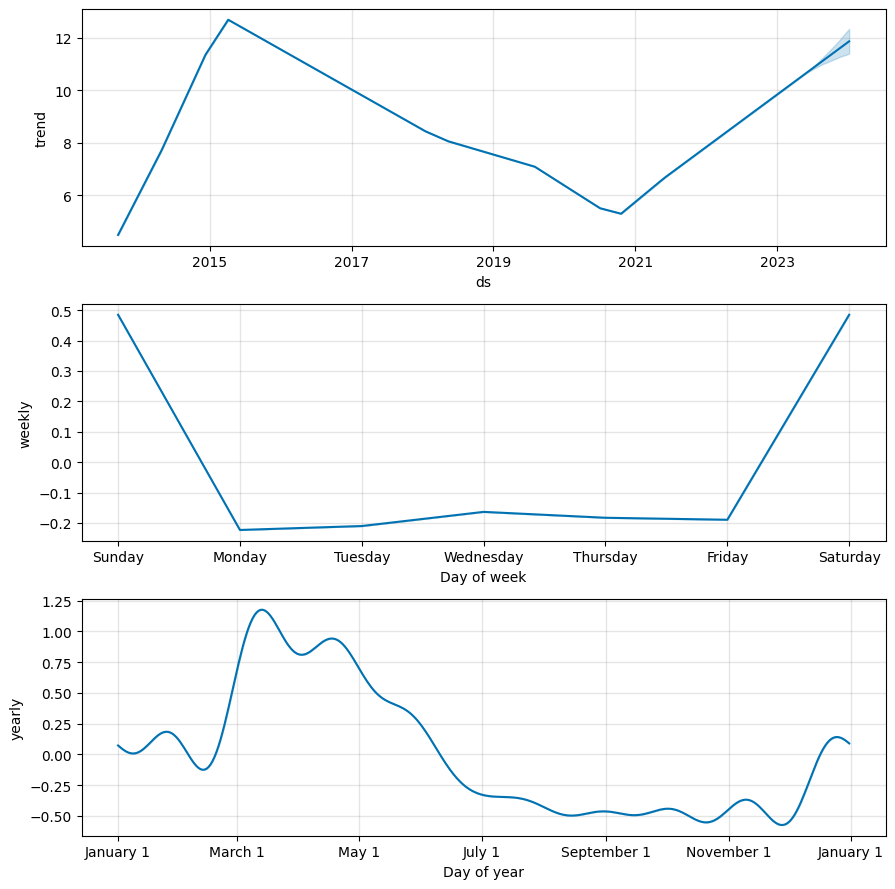

In [29]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

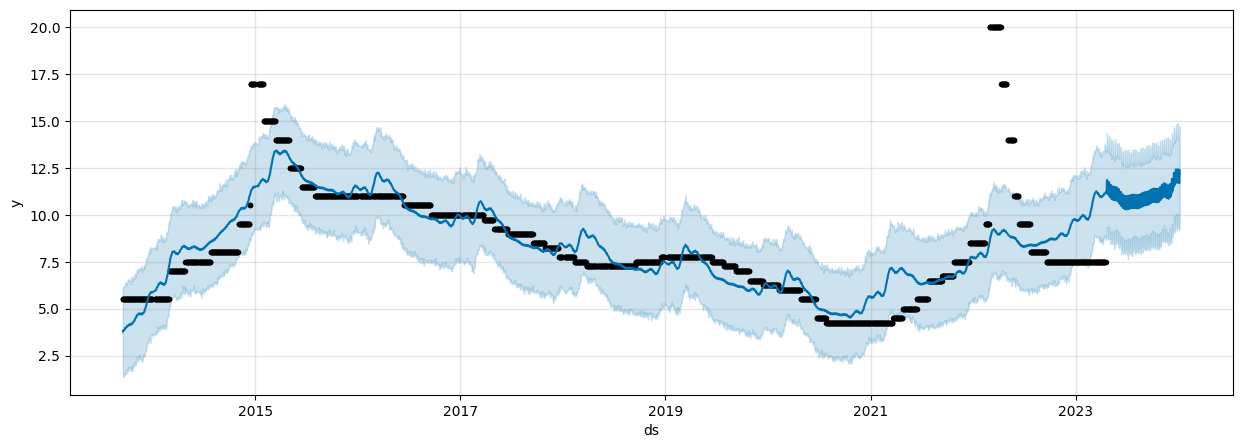

In [30]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [31]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-24,13.177537,10.524356,15.684337
260,2024-04-25,13.142328,10.494761,15.651172
261,2024-04-26,13.117866,10.363692,15.522293
262,2024-04-29,13.022162,10.517776,15.519516
263,2024-04-30,13.012907,10.507290,15.541267


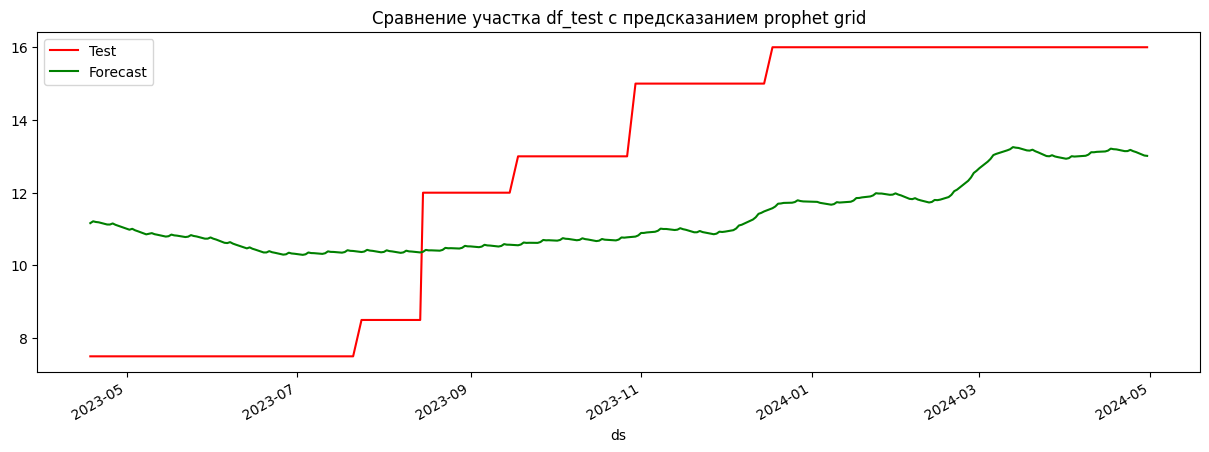

In [32]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [33]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.109367,0.264669,10.423208,3.228499
0,Prophet_with_holidays,3.111239,0.264666,10.450544,3.232730
0,Prophet_with_grid,3.092921,0.264294,10.309528,3.210845


In [34]:
# Сохранение модели в JSON файл
with open('../backend/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

# Baseline NeuralProphet on df_train для проверки модели

In [22]:
NeuralProphet_baseline = NeuralProphet()
NeuralProphet_baseline.set_plotting_backend("plotly-static")
metrics = NeuralProphet_baseline.fit(df_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.19% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (38) is too small than the required number                     for the learning rate finder (234). The results might not be optimal.
Missing logger folder: d:\Dropbox\Develop\Phyton Projects\MyProject\01_Prediction of the key rate in

Finding best initial lr:   0%|          | 0/234 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

# Обучение и прогнозирование курса на df

# Prophet baseline on df

In [10]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df)

02:23:20 - cmdstanpy - INFO - Chain [1] start processing
02:23:21 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Количество предсказанных дней
pred_days = 365

In [12]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3008,2025-04-26,16.680768,14.145904,19.477802
3009,2025-04-27,16.642159,14.006793,19.287661
3010,2025-04-28,15.849291,13.023298,18.484477
3011,2025-04-29,15.818141,13.204285,18.486147
3012,2025-04-30,15.813322,13.261114,18.700345


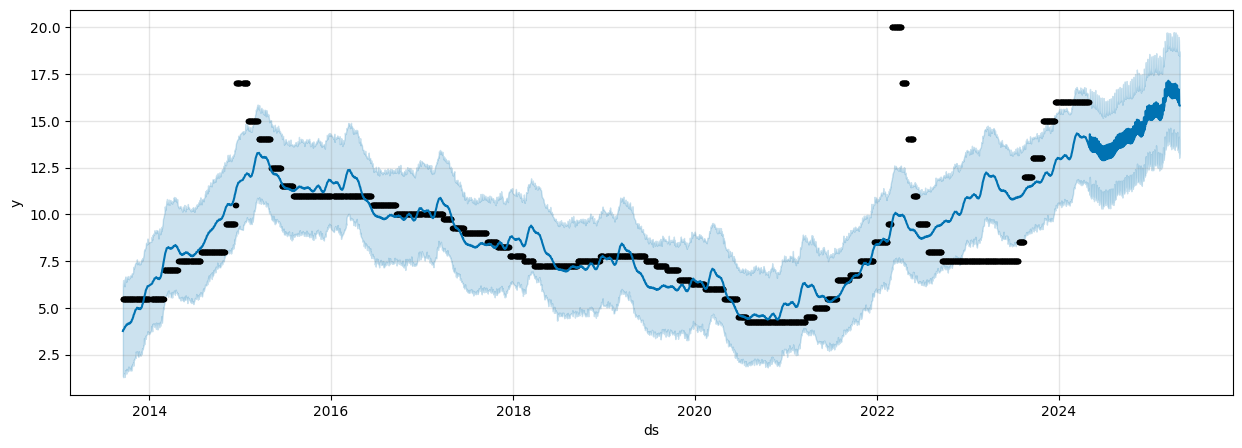

In [13]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

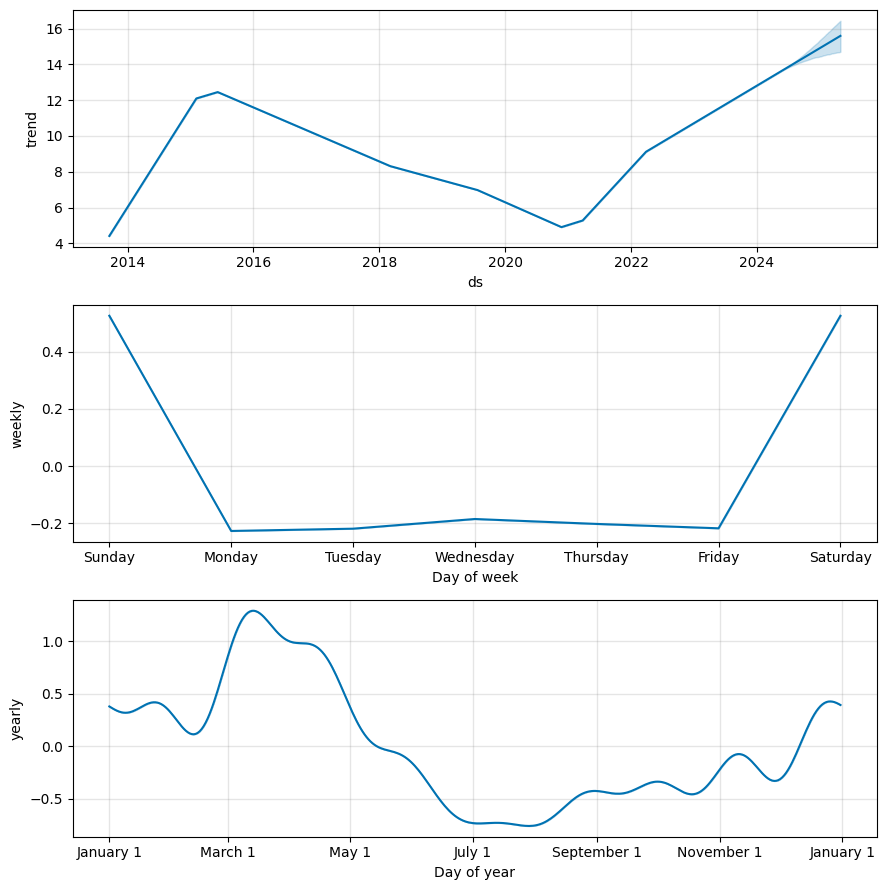

In [14]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()